In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import shift
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Reshape, Bidirectional, GRU, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2

2025-05-04 10:38:23.457242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746355103.682984      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746355103.746998      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os

dataset_path = "/kaggle/input/mpa-mlf-data-new/"
print(os.listdir(dataset_path))

['label_train.csv', 'test_format.csv', 'Test', 'Train']


In [3]:
# train_folder = "/content/MPA-MLF_DATA_NEW/Train"
# test_folder = "/content/MPA-MLF_DATA_NEW/Test"
# label_train_path = "/content/MPA-MLF_DATA_NEW/label_train.csv"
# test_format_path = "/content/MPA-MLF_DATA_NEW/test_format.csv"


train_folder = os.path.join(dataset_path, "Train") 
test_folder = os.path.join(dataset_path, "Test")
label_train_path = os.path.join(dataset_path, "label_train.csv")
test_format_path = os.path.join(dataset_path, "test_format.csv")


label_train_data = np.loadtxt(label_train_path, delimiter=',', skiprows=1, dtype=int)

X_train = []
for id in label_train_data[:, 0]:
    X_train.append(np.load(f"{train_folder}/{id}.npy"))
X_train = np.stack(X_train)

# X_train = np.stack([np.load(f"{train_folder}/{id}.npy") for id in label_train_data[:, 0]])
y_train = label_train_data[:, 1]

test_format_data = np.loadtxt(test_format_path, delimiter=',', skiprows=1, dtype=int)
X_test = []
for id in test_format_data[:, 0]:
    X_test.append(np.load(f"{test_folder}/{id}.npy"))
# y_test =test_format_data[:, 1]
X_test = np.stack(X_test)


In [4]:
def augment(sample, max_shift=2):
    time_shift = shift(sample, [0, np.random.randint(-max_shift, max_shift+1)], mode='nearest')
    freq_shift = shift(sample, [np.random.randint(-max_shift, max_shift+1), 0], mode='nearest')
    noise = sample + np.random.normal(0, 0.01, sample.shape)
    return [sample, time_shift, freq_shift, noise]

In [5]:
X, y = [], []
X = np.array(X)
y = np.array(y)
X = X_train
y = y_train

In [6]:
X_train_splitted, X_val, y_train_splitted, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
X_train_aug = []
y_train_aug = []
for x, y in zip(X_train, y_train):
    variants = augment(x)
    X_train_aug.extend(variants)
    y_train_aug.extend([y] * len(variants))

In [8]:
                                                                                                
X_train = np.array(X_train_aug).reshape(len(X_train_aug), -1)
X_val = X_val.reshape(len(X_val), -1)
y_train = np.array(y_train_aug)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [9]:
# def create_model_cnn(input_shape):
#     model = models.Sequential([
#         layers.Reshape((input_shape[0], input_shape[1], 1)),
        
#         layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
#         layers.MaxPooling2D((2, 2)),
        
#         layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#         layers.MaxPooling2D((2, 2)),
        
#         layers.Flatten(),
#         layers.Dense(64, activation='relu'),
#         layers.Dense(3, activation='softmax')  # 3 класса
#     ])
    
#     model.compile(optimizer='adam', 
#                  loss='sparse_categorical_crossentropy', 
#                  metrics=['accuracy'])
#     return model

In [10]:
model = models.Sequential([
        layers.Reshape((72,48, 1)),
layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(3, activation='softmax')  
    ])
    
model.compile(optimizer='adam', 
                 loss='sparse_categorical_crossentropy', 
                 metrics=['accuracy'])

2025-05-04 10:38:49.051488: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [11]:

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,            
    batch_size=32,
    verbose=1
)
                    

Epoch 1/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.9249 - loss: 0.2544 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 2/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.9973 - loss: 0.0089 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 3/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.9999 - loss: 8.3313e-04 - val_accuracy: 1.0000 - val_loss: 2.1754e-04
Epoch 4/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.9972 - loss: 0.0071 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 5/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.9996 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 6/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.9997 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 7/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 1.5214e-04
Epoch 8/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 1.0000 - los

In [12]:
val_score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', val_score[0])
print(f'Validation accuracy: {val_score[1]*100} %')

Validation loss: 1.1055561799366842e-06
Validation accuracy: 100.0 %


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


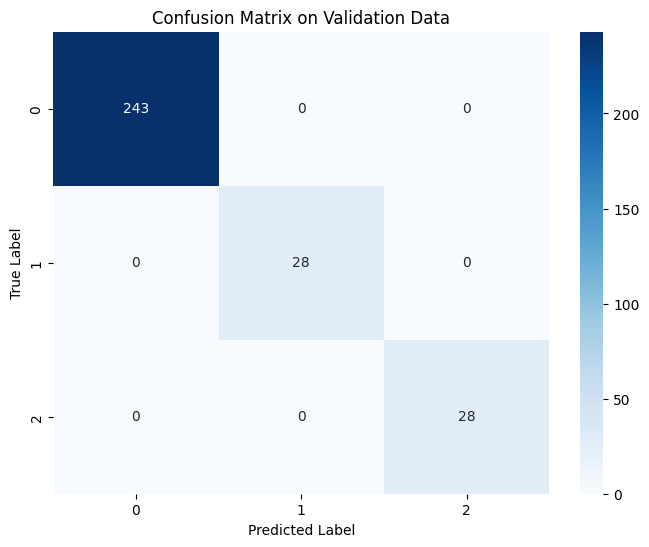

In [13]:
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = ['0', '1', '2']
cm = confusion_matrix(y_val, y_val_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix on Validation Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

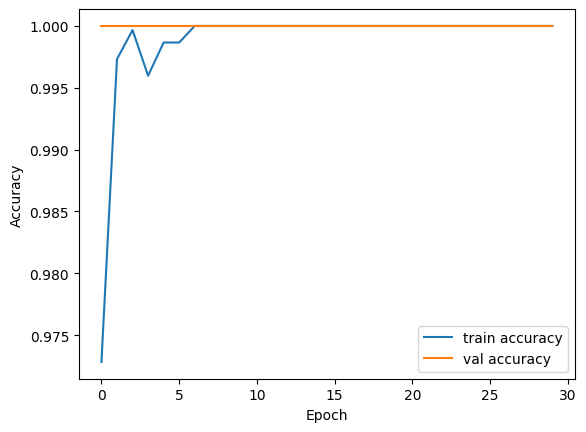

In [14]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
X_test_flat = X_test.reshape(len(X_test), -1)
X_test_scaled = scaler.transform(X_test_flat)


test_pred = model.predict(X_test_scaled)
test_pred_classes = np.argmax(test_pred, axis=1)

submission = pd.DataFrame({
    "ID": test_format_data[:, 0],
    "target": test_pred_classes  
})

submission.to_csv("/kaggle/working/submission.csv", index=False)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
